In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from binet import binet
from util import Number, random_matrix, random_matrices_for_ai
from strassen import Strassen, Strassen_no_pad
from ai import AI_multiplication
import time
from tqdm import tqdm

In [2]:
def reset_number_counter() -> None:
    Number.add_count = 0
    Number.sub_count = 0
    Number.mul_count = 0
    Number.div_count = 0

In [26]:
matlab_matrices = []
for size in [64, 128, 256, 512, 1024, 2048]:
    matrix = random_matrix(size)
    np.savetxt(f"./matrices/matrix_{size}.csv", matrix, delimiter=",")
    matlab_matrices.append(matrix)


[(64, 64), (128, 128), (256, 256)]


In [27]:
# Test numpy matmul vs matlab
matlab_results = np.array([0.000192, 0.000319, 0.000354, 0.00132, 0.00799, 0.058941])
python_results = []

for matrix in matlab_matrices[:-3]:
    t = time.time()
    matrix @ matrix
    t = time.time() - t
    python_results.append(f"{matrix.shape[0]}x{matrix.shape[0]}: {t}s")

print(matlab_results)


[0.000192 0.000319 0.000354 0.00132  0.00799  0.058941]


In [34]:
X = [64, 128, 256, 512, 1024, 2048]
print("MATLAB")
for i, n in enumerate(X):
    print(f"{n}x{n}: {matlab_results[i]}s")

print("\nPYTHON")
for i, n in enumerate(X[:-3]):
    print(python_results[i])

MATLAB
64x64: 0.000192s
128x128: 0.000319s
256x256: 0.000354s
512x512: 0.00132s
1024x1024: 0.00799s
2048x2048: 0.058941s

PYTHON
64x64: 0.30934834480285645s
128x128: 2.35215425491333s
256x256: 18.8021457195282s


In [3]:
type operation_count = tuple[int, int, int, int]
def analyse_matmul(A: np.ndarray, B: np.ndarray, func) -> tuple[operation_count, float]:
    start = time.time()
    func(A, B)
    duration = time.time() - start
    
    ops = Number.add_count, Number.sub_count, Number.mul_count, Number.div_count
    reset_number_counter()

    return ops, duration

In [4]:
df_binet = pd.DataFrame(columns=["A.size", "B.size", "Time", "Additions", "Subtractions", "Multiplications", "Divisions"])
df_strassen = pd.DataFrame(columns=["A.size", "B.size", "Time", "Additions", "Subtractions", "Multiplications", "Divisions"])

test_range = [2 ** i for i in range(0, 10, 1)]

reset_number_counter()

for i in tqdm(test_range):
    A = random_matrix(i)
    B = random_matrix(i)
    (add, sub, mul, div), duration = analyse_matmul(A, B, binet)
    df_binet.loc[i - 1] = {"A.size": A.shape[0], "B.size": B.shape[0], "Time": duration, "Additions": add, "Subtractions": sub, "Multiplications": mul, "Divisions": div}
    (add, sub, mul, div), duration = analyse_matmul(A, B, Strassen_no_pad)
    df_strassen.loc[i - 1] = {"A.size": A.shape[0], "B.size": B.shape[0], "Time": duration, "Additions": add, "Subtractions": sub, "Multiplications": mul, "Divisions": div}


100%|██████████| 10/10 [08:48<00:00, 52.87s/it]


Text(0, 0.5, 'Time [s]')

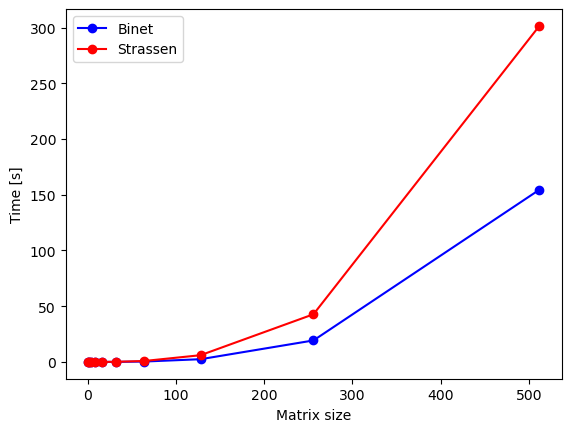

In [50]:
X = df_binet["A.size"]


plt.plot(X, df_binet["Time"], marker="o", color="blue", label="Multiplication time")
plt.plot(X, df_strassen["Time"], marker="o", color="red", label="Multiplication time")
plt.legend(["Binet", "Strassen"], loc="upper left")
plt.xlabel("Matrix size")
plt.ylabel("Time [s]")

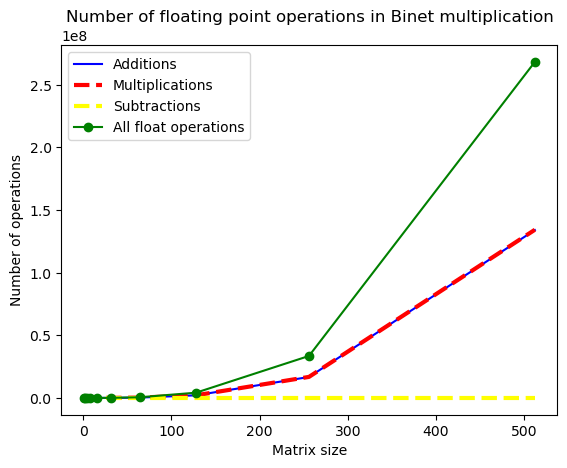

In [48]:
plt.plot(X, df_binet["Additions"], color="blue", label="Additions")
plt.plot(X, df_binet["Multiplications"], color="red", label="Multiplications", linewidth=3, linestyle="--")
plt.plot(X, df_binet["Subtractions"], color="yellow", label="Subtractions", linewidth=3, linestyle="--")
plt.plot(X, df_binet["Additions"] + df_binet["Multiplications"] + df_binet["Subtractions"], color="green", marker="o", label="All float operations")
plt.title("Number of floating point operations in Binet multiplication")
plt.xlabel("Matrix size")
plt.ylabel("Number of operations")
plt.legend()

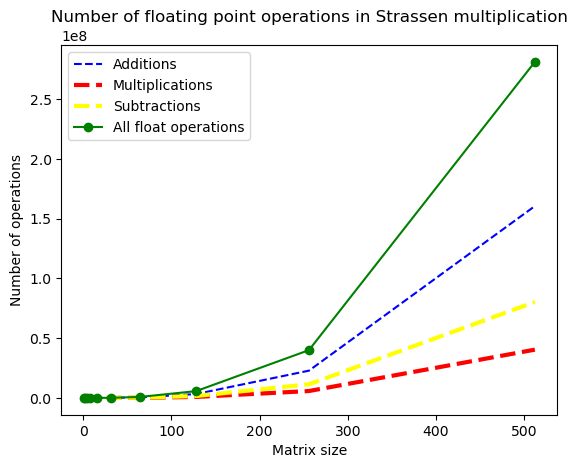

In [7]:
plt.title("Number of floating point operations in Strassen multiplication")
plt.plot(X, df_strassen["Additions"], color="blue", label="Additions", linestyle="--")
plt.plot(X, df_strassen["Multiplications"], color="red", label="Multiplications", linewidth=3, linestyle="--")
plt.plot(X, df_strassen["Subtractions"], color="yellow", label="Subtractions", linewidth=3, linestyle="--")
plt.plot(X, df_strassen["Additions"] + df_strassen["Multiplications"] + df_strassen["Subtractions"], color="green", marker="o", label="All float operations")
plt.xlabel("Matrix size")
plt.ylabel("Number of operations")
plt.legend()

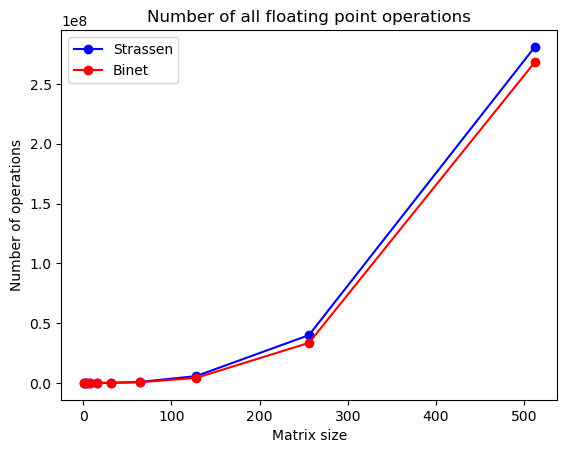

In [8]:
plt.plot(X, df_strassen["Additions"] + df_strassen["Multiplications"] + df_strassen["Subtractions"], color="blue", marker="o", label="Strassen")
plt.plot(X, df_binet["Additions"] + df_binet["Multiplications"] + df_binet["Subtractions"], color="red", marker="o", label="Binet")
plt.title("Number of all floating point operations")
plt.ylabel("Number of operations")
plt.xlabel("Matrix size")
plt.legend()

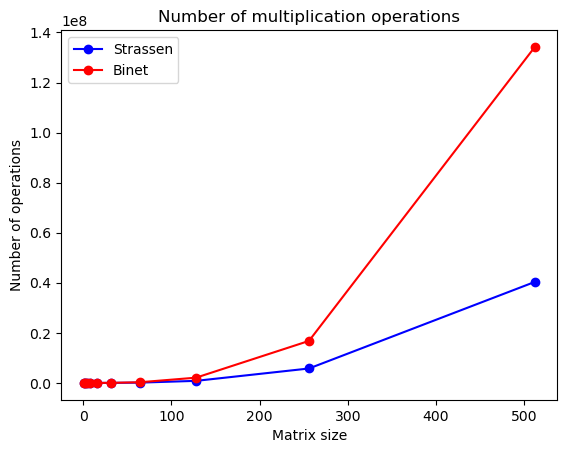

In [51]:
plt.plot(X, df_strassen["Multiplications"], color="blue", marker="o", label="Strassen")
plt.plot(X, df_binet["Multiplications"], color="red", marker="o", label="Binet")
plt.title("Number of multiplication operations")
plt.ylabel("Number of operations")
plt.xlabel("Matrix size")
plt.legend()

In [32]:
import itertools

df_ai = pd.DataFrame(columns=["N", "M", "Time", "Additions", "Subtractions", "Multiplications", "Divisions"])

pow_of_4 = [4 ** i for i in range(1, 10)]
pow_of_5 = [5 ** i for i in range(1, 10)]

test_range = list(itertools.product(pow_of_4, pow_of_5))

test_range.sort(key=lambda x : x[0] * x[1])

test_range = test_range[:40]
    

for n, m in tqdm(test_range):

    if n * m <= 10_000:
        A, B = random_matrices_for_ai(n, m)
        reset_number_counter()
        (add, sub, mul, div), duration = analyse_matmul(A, B, AI_multiplication)
        df_ai.loc[i] = {"N": n * m, "M": m * m, "Time": duration, "Additions": add, "Subtractions": sub, "Multiplications": mul, "Divisions": div}
        i += 1

100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


In [33]:
df_ai["Size of result"] = df_ai["M"] * df_ai["N"]

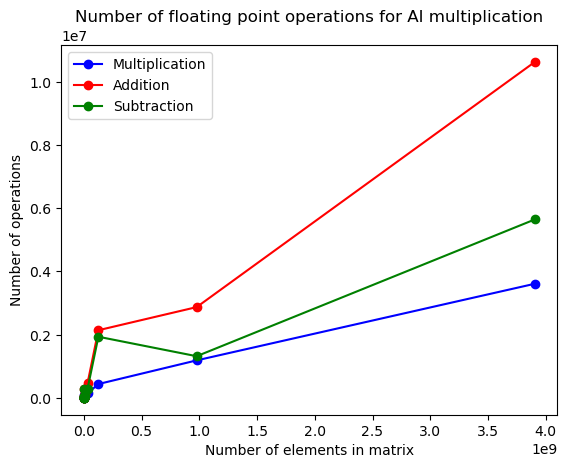

In [34]:
df_ai = df_ai.sort_values(by="Size of result")
X_ai = df_ai["Size of result"]
plt.plot(X_ai, df_ai["Multiplications"], color="blue", marker="o", label="Multiplication")
plt.plot(X_ai, df_ai["Additions"], color="red", marker="o", label="Addition")
plt.plot(X_ai, df_ai["Subtractions"], color="green", marker="o", label="Subtraction")
plt.title("Number of floating point operations for AI multiplication")
plt.ylabel("Number of operations")
plt.xlabel("Number of elements in matrix")
plt.legend()

In [35]:
X_normal = df_strassen["A.size"] * df_strassen["B.size"]

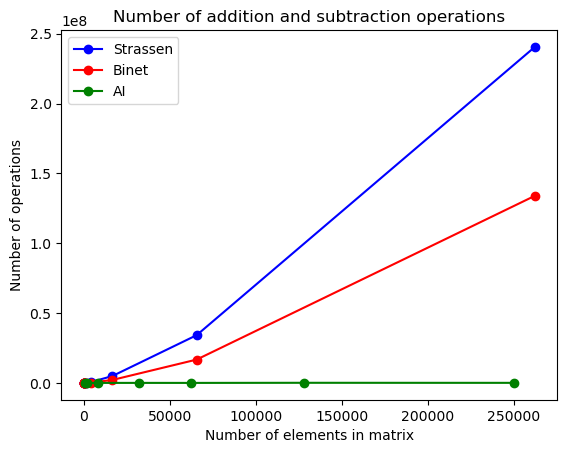

In [60]:
plt.plot(X_normal, df_strassen["Additions"] + df_strassen["Subtractions"], color="blue", marker="o", label="Strassen")
plt.plot(X_normal, df_binet["Additions"] + df_binet["Subtractions"], color="red", marker="o", label="Binet")
plt.plot(X_ai[:7], df_ai["Additions"][:7] + df_ai["Subtractions"][:7], color="green", marker="o", label="AI")
plt.title("Number of addition and subtraction operations")
plt.ylabel("Number of operations")
plt.xlabel("Number of elements in matrix")
plt.legend()

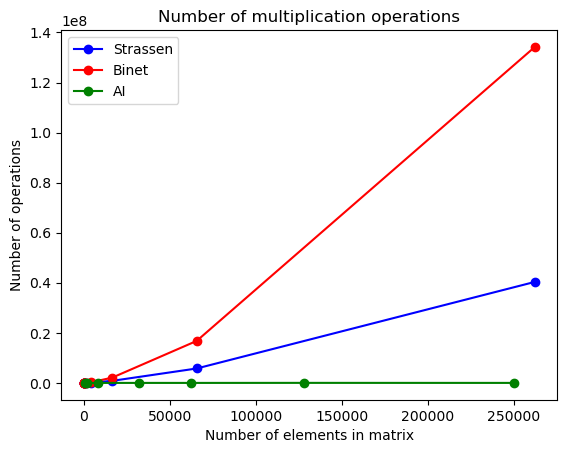

In [58]:
plt.plot(X_normal, df_strassen["Multiplications"], color="blue", marker="o", label="Strassen")
plt.plot(X_normal, df_binet["Multiplications"], color="red", marker="o", label="Binet")
plt.plot(X_ai[:7], df_ai["Multiplications"][:7], color="green", marker="o", label="AI")
plt.title("Number of multiplication operations")
plt.ylabel("Number of operations")
plt.xlabel("Number of elements in matrix")
plt.legend()

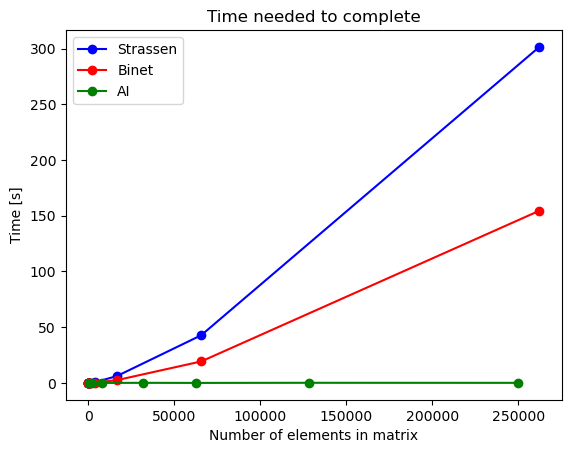

In [55]:
plt.plot(X_normal, df_strassen["Time"], color="blue", marker="o", label="Strassen")
plt.plot(X_normal, df_binet["Time"], color="red", marker="o", label="Binet")
plt.plot(X_ai[:7], df_ai["Time"][:7], color="green", marker="o", label="AI")
plt.title("Time needed to complete")
plt.ylabel("Time [s]")
plt.xlabel("Number of elements in matrix")
plt.legend()

In [41]:
df_binet.to_latex("df_binet.txt")

Text(0, 0.5, 'Time [s]')

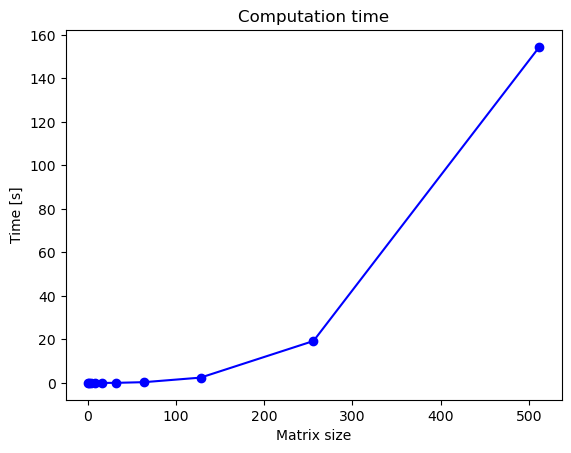

In [44]:
X = df_binet["A.size"]

plt.plot(X, df_binet["Time"], marker="o", color="blue", label="Multiplication time")
plt.plot(X, df_strassen["Time"], marker="o", color="blue", label="Multiplication time")
plt.title("Computation time")
plt.xlabel("Matrix size")
plt.ylabel("Time [s]")

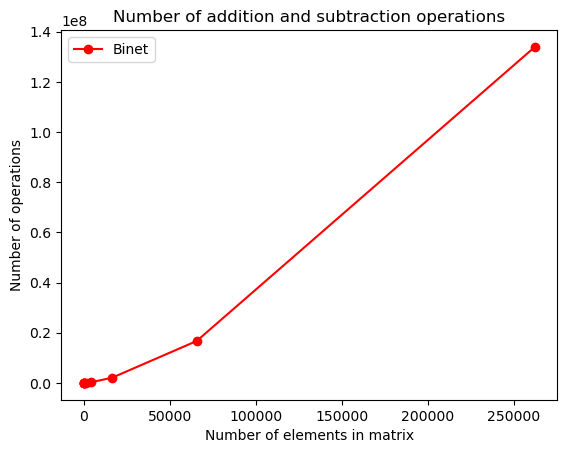

In [45]:
# plt.plot(X_normal, df_strassen["Additions"] + df_strassen["Subtractions"], color="blue", marker="o", label="Strassen")
plt.plot(X_normal, df_binet["Additions"] + df_binet["Subtractions"], color="red", marker="o", label="Binet")
# plt.plot(X_ai, df_ai["Additions"] + df_ai["Subtractions"], color="green", marker="o", label="AI")
plt.title("Number of addition and subtraction operations")
plt.ylabel("Number of operations")
plt.xlabel("Number of elements in matrix")
plt.legend()

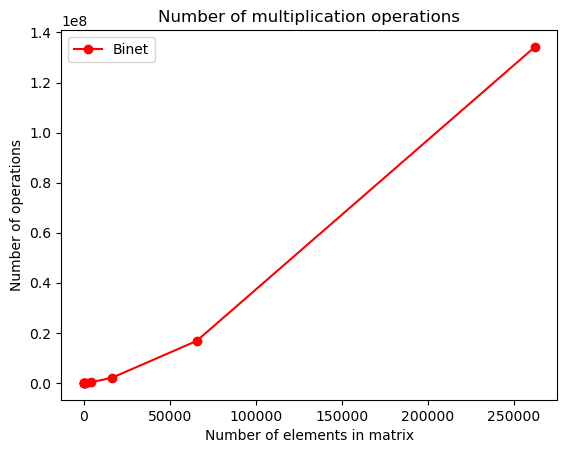

In [46]:
# plt.plot(X_normal, df_strassen["Multiplications"], color="blue", marker="o", label="Strassen")
plt.plot(X_normal, df_binet["Multiplications"], color="red", marker="o", label="Binet")
# plt.plot(X_ai[:5], df_ai["Multiplications"][:5], color="green", marker="o", label="AI")
plt.title("Number of multiplication operations")
plt.ylabel("Number of operations")
plt.xlabel("Number of elements in matrix")
plt.legend()

In [49]:
df_strassen.to_latex("df_strassen.txt")

In [53]:
df_ai.to_latex("df_ai.txt")